In [2]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution, maplotlib_plot_map as plot_map

In [30]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,19464,None,None,88618.905609
2020-06-13,19465,None,None,81901.050844
2020-06-14,19466,None,None,75714.905335
2020-06-15,19467,None,None,70062.102746
2020-06-16,19468,None,None,65116.531051
...,...,...,...,...
2020-12-19,19654,None,None,344769.712608
2020-12-20,19655,None,None,361089.508094
2020-12-21,19656,None,None,379506.802441


In [31]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/Downloads/zoe_uk_active_cases_2020-12-23_2020-12-23-16-10.pickle


In [32]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/Downloads/zoe_uk_active_cases_2020-12-22_2020-12-22-19-13.pickle


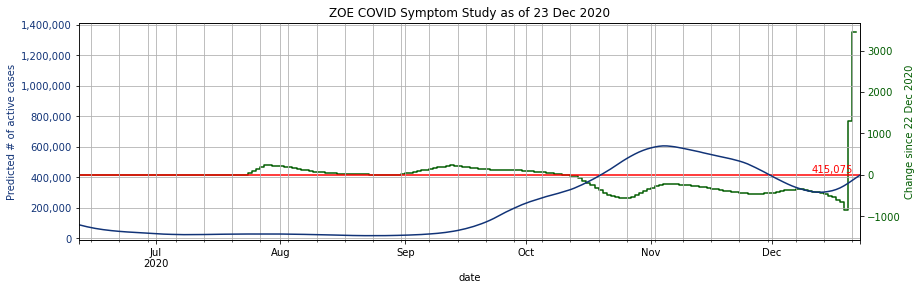

In [33]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

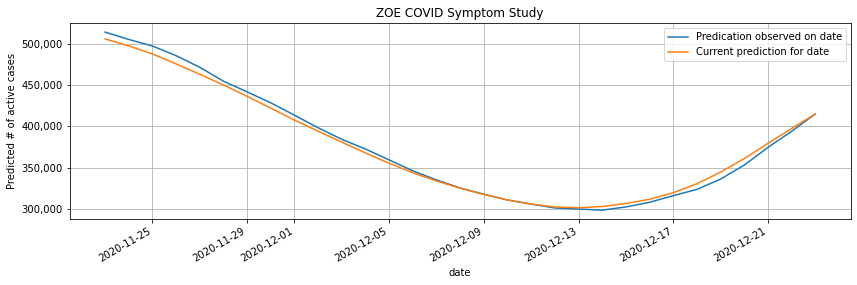

In [34]:
plot_study_evolution(curr_date, days=30)

In [35]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)
prevalence_map

,cartodb_id,the_geom,the_geom_webmercator,objectid,lad16cd,lad16nm,lad16nmw,bng_e,bng_n,long,...,discrete_percentage,discrete_cases_pm,discrete_cases_p100k,percentage_string,cases_pm_string,cases_p100k_string,cases_string,data_status,country,region
0,21115,0103000020E610000001000000C4010000AD9CD15F9CE2...,0103000020110F000001000000C401000034EC1A1775E3...,1,E06000001,Hartlepool,None,447157,531476,-1.27023,...,-1.0,-1,NaN,Not enough contributors,Not enough contributors,Not enough contributors,Not enough contributors,05:00:02 23-12-2020,England,North East
1,21116,0106000020E61000000200000001030000000100000013...,0106000020110F00000200000001030000000100000013...,2,E06000002,Middlesbrough,None,451141,516887,-1.21099,...,0.1,1000,1000,0.9 %,8634,863,1206,05:00:02 23-12-2020,England,North East
2,21117,0106000020E61000000200000001030000000100000006...,0106000020110F00000200000001030000000100000006...,3,E06000003,Redcar and Cleveland,None,464359,519597,-1.00611,...,0.1,50,50,0.2 %,1667,167,226,05:00:02 23-12-2020,England,North East
3,21118,0106000020E61000000200000001030000000100000025...,0106000020110F00000200000001030000000100000025...,4,E06000004,Stockton-on-Tees,None,444937,518183,-1.30669,...,0.1,500,500,0.5 %,4553,455,891,05:00:02 23-12-2020,England,North East
4,21119,0103000020E610000001000000B10200005CD5D7207503...,0103000020110F000001000000B10200005FAC44E29D8B...,5,E06000005,Darlington,None,428029,515649,-1.56835,...,0.1,50,50,0.2 %,1998,200,211,05:00:02 23-12-2020,England,North East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
386,21484,0106000020E610000002000000010300000001000000B0...,0106000020110F000002000000010300000001000000B0...,389,W06000022,Newport,Casnewydd,337897,187433,-2.89769,...,0.1,1000,1000,3.0 %,30011,3001,4566,05:00:02 23-12-2020,Wales,Wales
387,21485,0103000020E6100000010000006D1000003E242470162E...,0103000020110F0000010000006D10000075DF530DAA62...,390,W06000023,Powys,Powys,302328,273254,-3.43533,...,0.1,1000,1000,1.0 %,10027,1003,1310,05:00:02 23-12-2020,Wales,Wales
388,21486,0103000020E61000000100000060010000CAAE459CF9AC...,0103000020110F000001000000600100003FE916C4D9A7...,391,W06000024,Merthyr Tydfil,Merthyr Tudful,305916,206424,-3.36425,...,-1.0,-1,NaN,Not enough contributors,Not enough contributors,Not enough contributors,Not enough contributors,05:00:02 23-12-2020,Wales,Wales
389,21487,0103000020E610000001000000C0000000CA21EFF2CDF8...,0103000020110F000001000000C0000000DEAADBECED86...,325,E09000032,Wandsworth,None,525152,174137,-0.20021,...,0.1,1000,1000,1.1 %,11250,1125,3656,05:00:02 23-12-2020,England,London


In [36]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/Downloads/zoe_prevalence_map_2020-12-23_2020-12-23-16-10.pickle


In [37]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
381,Rhondda Cynon Taf,W06000016,3.875102
344,Cardiff,W06000015,3.685626
340,Neath Port Talbot,W06000012,3.106373
386,Newport,W06000022,3.001076
341,Bridgend,W06000013,2.357347
384,Torfaen,W06000020,2.251308
370,Redbridge,E09000026,2.184650
382,Caerphilly,W06000018,2.179922
339,Swansea,W06000011,2.062134
334,Wrexham,W06000006,1.884173


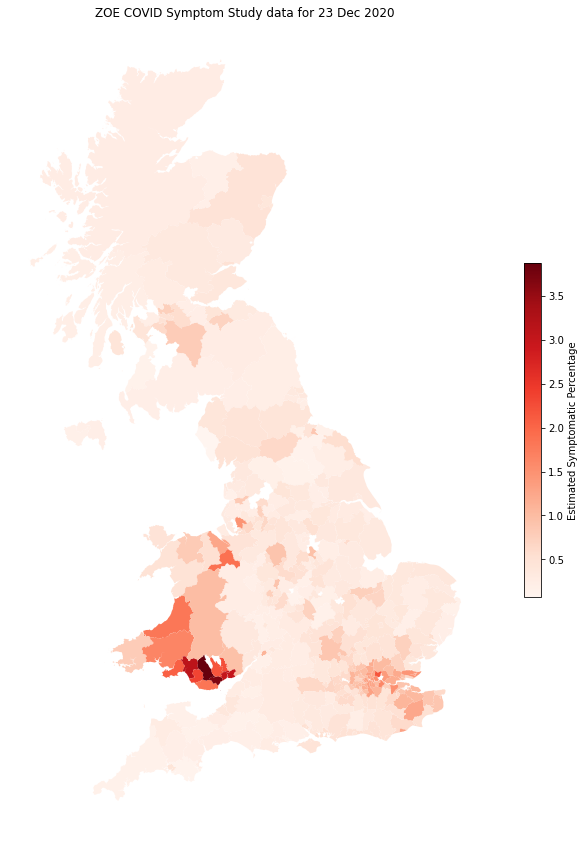

In [38]:
plot_map()